In [1]:
import multiprocessing
from gensim.models import Word2Vec

import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from sklearn import model_selection
from sklearn.utils import shuffle

In [2]:
data_dir = './api_data'
ignore_files = []
data_files = os.listdir(data_dir)
files = list(set(data_files)-set(ignore_files))

categories = files

predict_from = {'abstract': True, 'title': False, 'full_page': False}

files_codes = dict(zip(files, range(0, len(files))))
do_preproc = False

In [3]:
def create_df(route, label):
    pages_df = pd.DataFrame(columns=['document', 'category'])
    f = open(route, "rt", errors='ignore')
    articles = f.read()
    f.close()
    soup_atricles = BeautifulSoup(articles, 'xml')
    article_list = soup_atricles.find_all('PubmedArticle')
    for article, i in zip(article_list, range(0, len(article_list))):
        extracted = ''
        if predict_from['full_page']:
            extracted = article.get_text()
        elif predict_from['title']:
            extracted = article.find('ArticleTitle').get_text()
        elif predict_from['abstract']:
            maybe_abstract = article.find("Abstract")
            if maybe_abstract:
                extracted = maybe_abstract.get_text()
        
        extracted = re.sub("\W"," ",extracted)
        extracted = re.sub(r" +"," ",extracted)
        
        pages_df.loc[i] = (extracted, label)
    return pages_df

In [4]:
all_pages = pd.DataFrame(columns=['document', 'category', 'label'])

train_x = pd.Series()
valid_x = pd.Series()
train_y = pd.Series()
valid_y = pd.Series()

for file_name in files_codes:
    category = file_name.split('_')[0]
    code = files_codes[file_name]
    
    #Drop empty rows
    pages_df = create_df(data_dir+f'/{file_name}', category)
    pages_df.replace('', np.nan, inplace=True)
    pages_df.dropna(subset=['document'], inplace=True)

    pages_df['label'] =code
    
    all_pages = all_pages.append(pages_df, ignore_index=True)
    
    #Representative train-val sets
    train_x_, valid_x_, train_y_, valid_y_ = model_selection.train_test_split(pages_df['document'], pages_df['label'], test_size =  0.15)
    
    #Append to main dataframe
    train_x = train_x.append(train_x_, ignore_index=True)
    valid_x = valid_x.append(valid_x_, ignore_index=True)
    train_y = train_y.append(train_y_, ignore_index=True)
    valid_y = valid_y.append(valid_y_, ignore_index=True)
    print(category, "-ready")
train_x, train_y = shuffle(train_x, train_y, random_state=42)
valid_x, valid_y = shuffle(valid_x, valid_y, random_state=42)

asthma -ready
COPD -ready
lungcancer -ready
cysticfibrosis -ready
flu -ready
acutebronchitis -ready
pneumonia -ready


In [5]:
all_pages.document = all_pages.apply(lambda x: x.document.lower(), axis = 1)

In [6]:
all_pages['doc_list'] = all_pages.apply(lambda x: x.document.split(), axis = 1)

In [7]:
all_pages['doc_list_len'] = all_pages.apply(lambda x: len(x.doc_list), axis = 1)
all_pages['doc_list_len'].describe()

count    6207.000000
mean      245.030127
std        95.749661
min         0.000000
25%       190.000000
50%       249.000000
75%       290.000000
max      1079.000000
Name: doc_list_len, dtype: float64

In [8]:
a = np.array(all_pages.label.astype(int))
deep_target = np.zeros((a.size, a.max()+1))
deep_target[np.arange(a.size),a] = 1
deep_target

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
model = Word2Vec(all_pages['doc_list'], size=200, window=5, min_count=1, workers=4)

In [10]:
from keras.preprocessing import text, sequence
from tensorflow.keras import layers, models, optimizers

Using TensorFlow backend.


In [11]:
dataset = np.zeros(shape=(all_pages.shape[0], 200) )

### TF-IDF scores

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# our corpus
data = all_pages['document']

cv = CountVectorizer()

# convert text data into term-frequency matrix
data = cv.fit_transform(data)

tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))

dictis = {}
for word, score in word2tfidf.items():
    dictis[word] = score

### Doc to vec

In [13]:
for ind, row in all_pages.iterrows():
    sentence_vec = np.zeros(shape = (200,))
    for word in row['doc_list']:
        if word in dictis:
            word_vec = model[word] * dictis[word]
        else:
            word_vec = model[word]
        sentence_vec = np.add(word_vec, sentence_vec)
    sentence_vec = sentence_vec / len(row['doc_list'])
    dataset[ind] = sentence_vec *10

C:\Users\ivani\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\ivani\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\ivani\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


## Shallow neural net

In [14]:
import tensorflow as tf

In [15]:
input_size = dataset[0].shape

In [16]:
dataset = tf.keras.utils.normalize(dataset)

In [17]:
nans = np.isnan(dataset)
dataset[nans] = 0

In [34]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(dataset, deep_target, test_size =  0.15)

In [19]:
# create input layer 
input_layer = layers.Input(input_size, sparse=True)

# create hidden layer
hidden_layer = layers.Dense(200, activation="tanh")(input_layer)

# create output layer
output_layer = layers.Dense(7, activation="softmax")(hidden_layer)

classifier = models.Model(inputs = input_layer, outputs = output_layer)
classifier.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [20]:
classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1407      
Total params: 41,607
Trainable params: 41,607
Non-trainable params: 0
_________________________________________________________________


In [21]:
classifier.fit(x=train_x, y=train_y, batch_size=30, epochs=30)
classifier.evaluate(x=valid_x, y=valid_y)

Epoch 1/30
176/176 [==============================] - 0s 2ms/step - loss: 1.6388 - accuracy: 0.4091
Epoch 2/30
176/176 [==============================] - 0s 2ms/step - loss: 1.3136 - accuracy: 0.5488
Epoch 3/30
176/176 [==============================] - 0s 2ms/step - loss: 1.1885 - accuracy: 0.5892
Epoch 4/30
176/176 [==============================] - 0s 2ms/step - loss: 1.1266 - accuracy: 0.6173
Epoch 5/30
176/176 [==============================] - 0s 2ms/step - loss: 1.0887 - accuracy: 0.6356
Epoch 6/30
176/176 [==============================] - 0s 2ms/step - loss: 1.0617 - accuracy: 0.6370
Epoch 7/30
176/176 [==============================] - 0s 2ms/step - loss: 1.0413 - accuracy: 0.6491
Epoch 8/30
176/176 [==============================] - 0s 2ms/step - loss: 1.0252 - accuracy: 0.6493
Epoch 9/30
176/176 [==============================] - 0s 2ms/step - loss: 1.0160 - accuracy: 0.6535
Epoch 10/30
176/176 [==============================] - 0s 2ms/step - loss: 1.0039 - accuracy: 0.6635

[0.8977372050285339, 0.6952789425849915]

In [22]:
predicts = classifier.predict(valid_x)

In [30]:
predictions = predicts.argmax(axis=-1)
valid_y = valid_y.argmax(axis=-1)

In [31]:
from sklearn.metrics import confusion_matrix

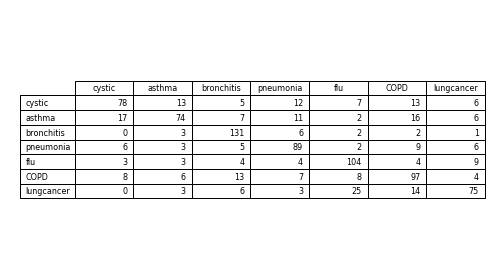

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()

# hide axes

ax.axis('off')
ax.axis('tight')
labels = ['cystic', 'asthma', 'bronchitis', 'pneumonia', 'flu', 'COPD', 'lungcancer']
ax.table(cellText=confusion_matrix(valid_y, predictions), colLabels=labels, rowLabels =labels,  loc='center')
fig.tight_layout()

plt.show()

## LSTM

In [35]:
dataset = np.zeros(shape=(all_pages.shape[0], 300, 200) )

In [36]:
for ind, row in all_pages.iterrows():
    sentence_vec = np.zeros(shape = (300, 200))
    for i, word in enumerate(row['doc_list'][0:300]):
        if word in dictis:
            word_vec = model[word] * dictis[word]
        else:
            word_vec = model[word]
        sentence_vec[i] = word_vec * 10
    dataset[ind] = sentence_vec

C:\Users\ivani\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys
C:\Users\ivani\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [37]:
input_size = dataset[0].shape

In [38]:
dataset = tf.keras.utils.normalize(dataset)

In [39]:
nans = np.isnan(dataset)
dataset[nans] = 0

In [40]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(dataset, deep_target, test_size =  0.15)

In [41]:
input_layer = layers.Input(input_size)
lstm_layer = layers.LSTM(300)(input_layer)
output_layer1 = layers.Dense(100, activation="tanh")(lstm_layer)
output_layer2 = layers.Dense(7, activation="softmax")(output_layer1)

classifier = models.Model(inputs = input_layer, outputs = output_layer2)
classifier.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [42]:
classifier.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 200)]        0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 341,607
Trainable params: 341,607
Non-trainable params: 0
_________________________________________________________________


In [43]:
classifier.fit(x=train_x, y=train_y, batch_size=30, epochs=30)
classifier.evaluate(x=valid_x, y=valid_y)

Epoch 1/30
176/176 [==============================] - 10s 59ms/step - loss: 1.9484 - accuracy: 0.1687
Epoch 2/30
176/176 [==============================] - 9s 52ms/step - loss: 1.9416 - accuracy: 0.1693
Epoch 3/30
176/176 [==============================] - 9s 54ms/step - loss: 1.9229 - accuracy: 0.1761
Epoch 4/30
176/176 [==============================] - 9s 52ms/step - loss: 1.8942 - accuracy: 0.2093
Epoch 5/30
176/176 [==============================] - 9s 52ms/step - loss: 1.9582 - accuracy: 0.1589
Epoch 6/30
176/176 [==============================] - 9s 52ms/step - loss: 1.9293 - accuracy: 0.1723
Epoch 7/30
121/176 [===================>..........] - ETA: 2s - loss: 1.9317 - accuracy: 0.16

KeyboardInterrupt: 